In [171]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
color = sns.color_palette()
sns.set_style('darkgrid')

In [176]:
train = pd.read_csv('cs_train1.csv')
train['date'] = pd.to_datetime(train['date'], format="%d-%m-%Y")
train.head()

,date,store,item,sales
0,2013-01-01,1,24852,13
1,2013-01-02,1,24852,11
2,2013-01-03,1,24852,14
3,2013-01-04,1,24852,13
4,2013-01-05,1,24852,10


In [177]:
train.shape

(913000, 4)

In [178]:
# per 1 store, 1 item
train_df = train[train['store']==1]
train_df = train_df[train['item']==24852]
# train_df = train_df.set_index('date')
train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday
train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,24852,13,2013,1,1,1
1,2013-01-02,1,24852,11,2013,1,2,2
2,2013-01-03,1,24852,14,2013,1,3,3
3,2013-01-04,1,24852,13,2013,1,4,4
4,2013-01-05,1,24852,10,2013,1,5,5


In [179]:
train_df.tail()

,date,store,item,sales,year,month,day,weekday
1821,2017-12-27,1,24852,14,2017,12,361,2
1822,2017-12-28,1,24852,19,2017,12,362,3
1823,2017-12-29,1,24852,15,2017,12,363,4
1824,2017-12-30,1,24852,27,2017,12,364,5
1825,2017-12-31,1,24852,23,2017,12,365,6


In [180]:
len(train_df)

1826

# Decompose the time series

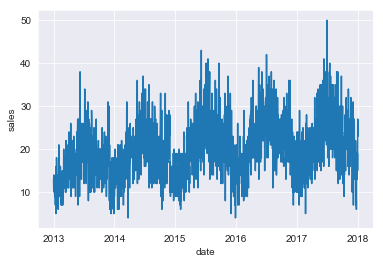

In [181]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

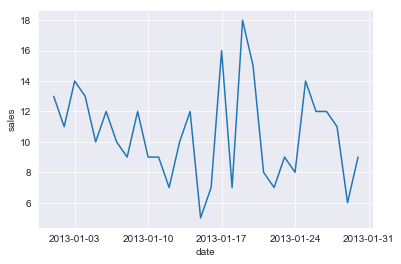

In [182]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:30])

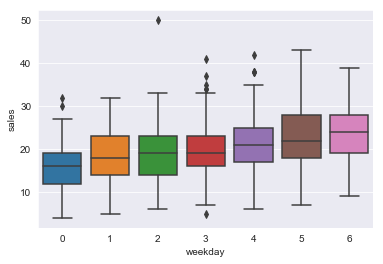

In [183]:
sns.boxplot(x="weekday", y="sales", data=train_df)

In [184]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,24852,13.0,2013,1,1,1
2013-01-02,1,24852,11.0,2013,1,2,2
2013-01-03,1,24852,14.0,2013,1,3,3
2013-01-04,1,24852,13.0,2013,1,4,4
2013-01-05,1,24852,10.0,2013,1,5,5


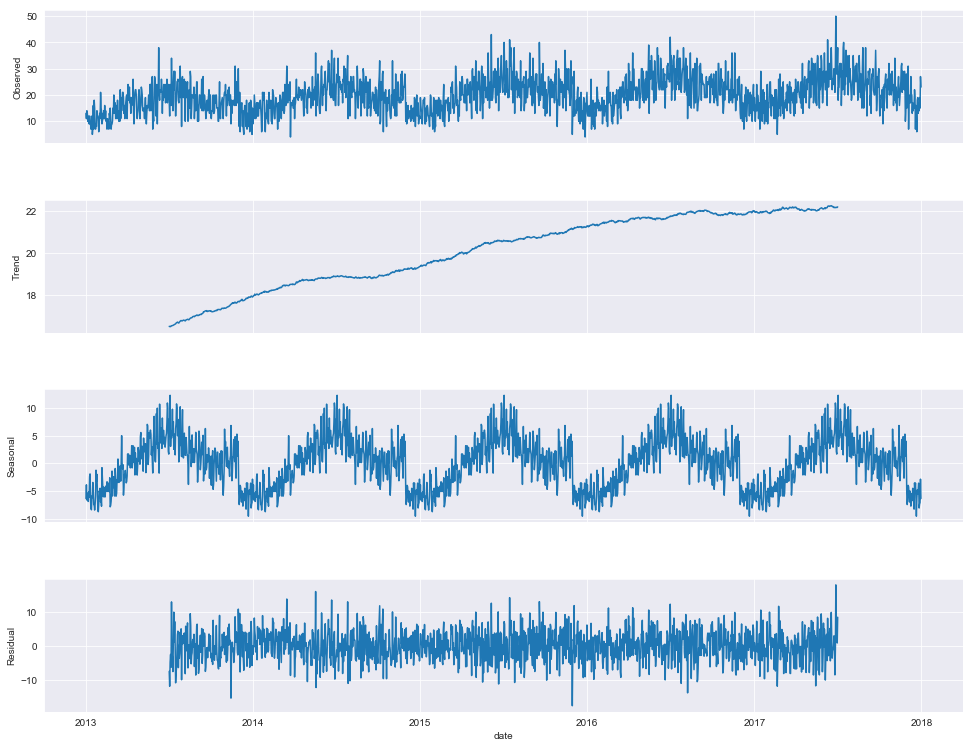

In [185]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

# Check Stationarity

In [186]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    #Smaller the p-value, more likely the time series is stationary
    print(dfoutput)

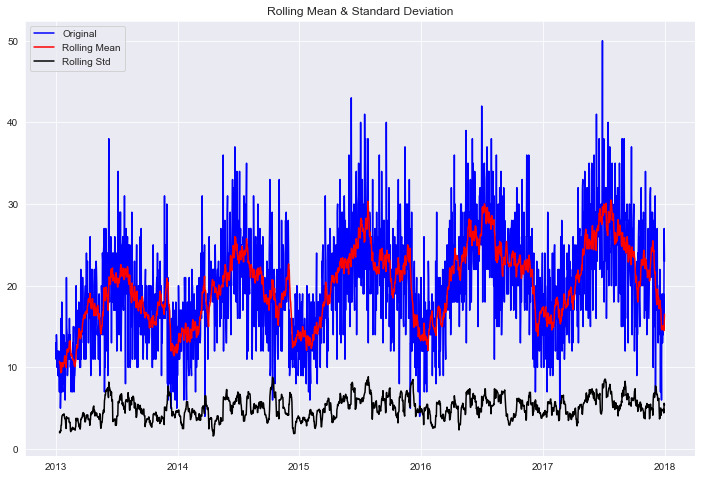

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [187]:
test_stationarity(train_df['sales'])

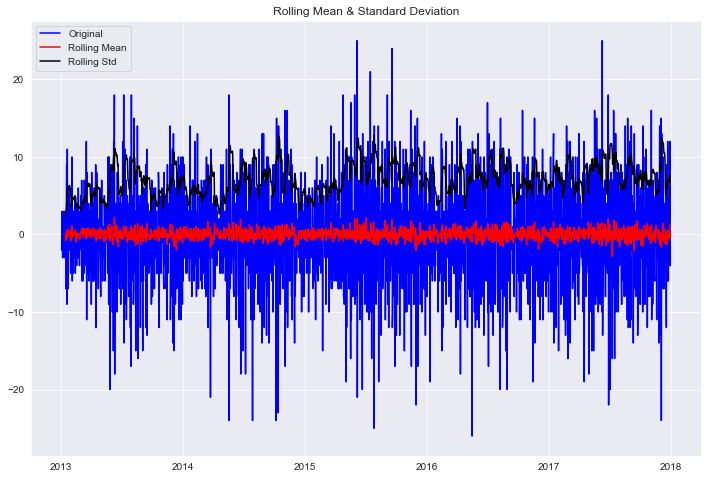

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [188]:
#Differencing to make time series stationary
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

# ACF and PCF

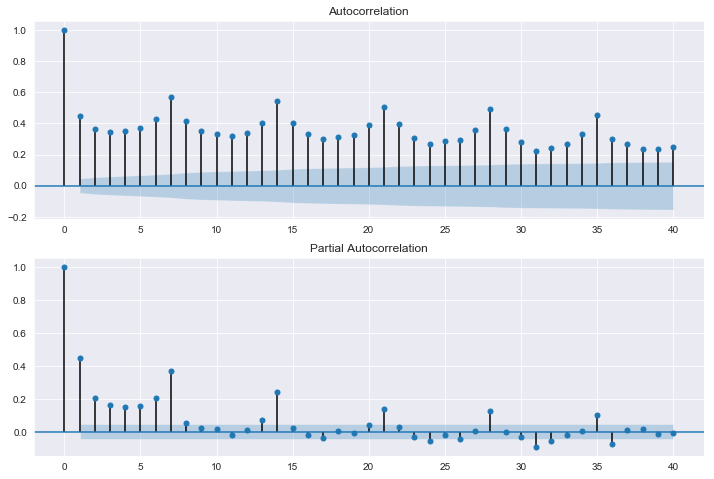

In [189]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)

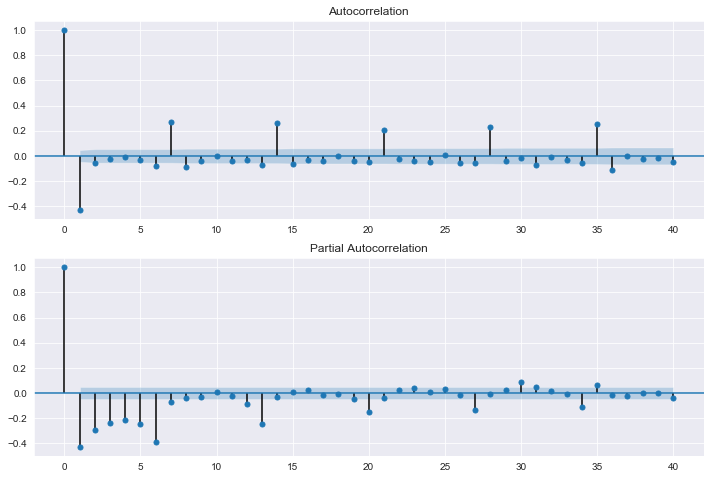

In [190]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

# Applying ARIMA

In [191]:
arima_model = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)

# Analyze the result

NormaltestResult(statistic=16.426384818901713, pvalue=0.000271054023172714)


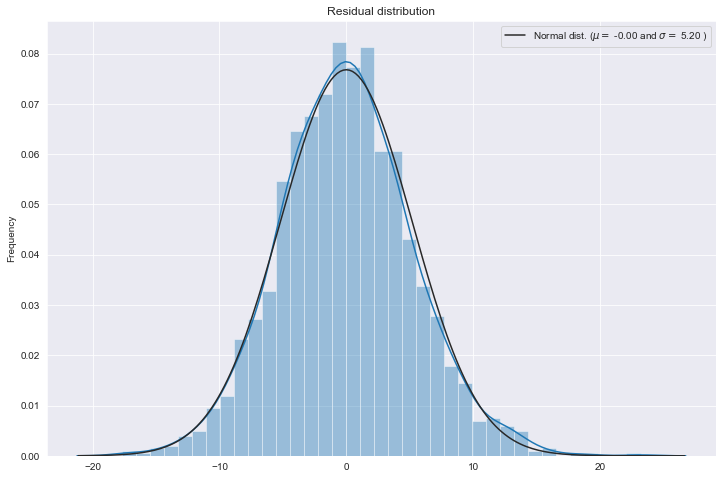

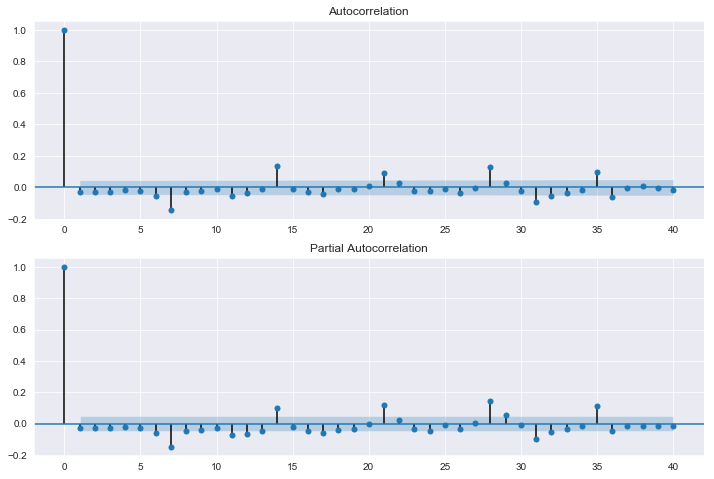

In [192]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_model.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_model.resid, lags=40, ax=ax2)

# Consider seasonality affect by SARIMA

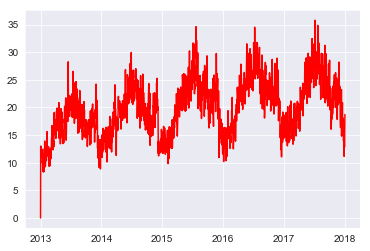

In [193]:
sarima_model = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
plt.plot(sarima_model.fittedvalues, color='red')
plt.show()

NormaltestResult(statistic=16.74269014620744, pvalue=0.0002314040888974918)


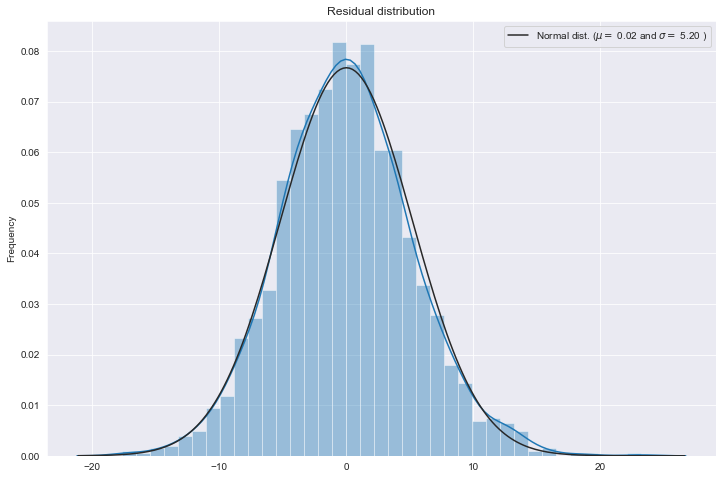

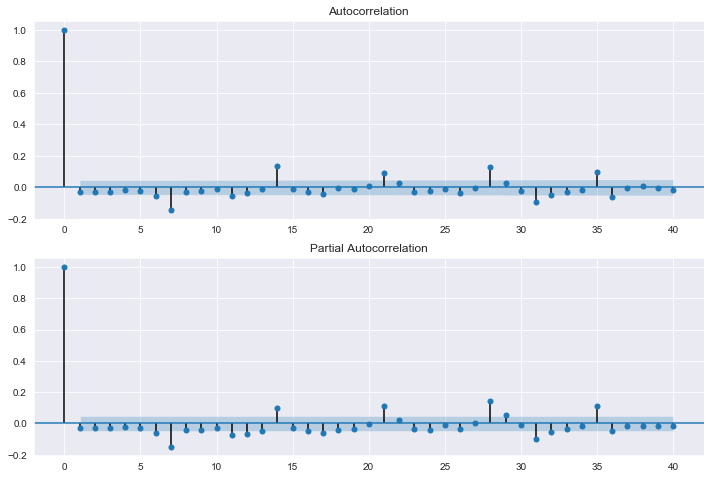

In [194]:
resid = sarima_model.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_model.resid, lags=40, ax=ax2)

## Make prediction and evaluation

Take the last 3 months in training set as validation data

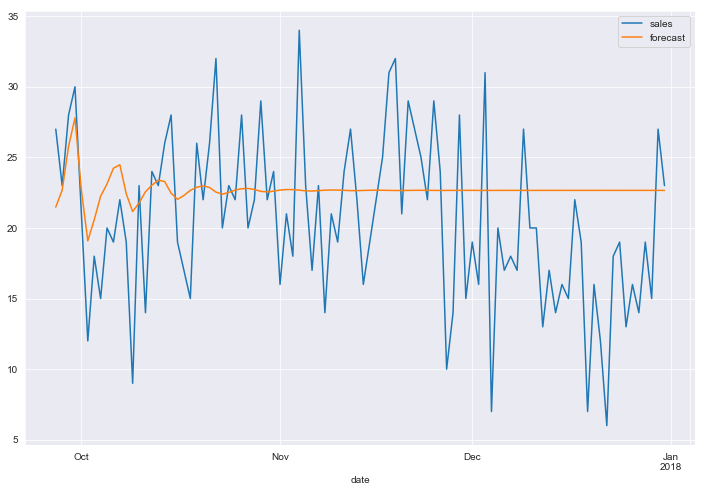

In [195]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_model.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [196]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100  # Mean Absolute %age Error
    print('MAPE: %.2f' %(mape),"%")

In [197]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 %


In [198]:
print(sarima_model.forecast(steps=30))

2018-01-01    16.845946
2018-01-02    17.204741
2018-01-03    17.073020
2018-01-04    18.873595
2018-01-05    18.458846
2018-01-06    22.104218
2018-01-07    20.480745
2018-01-08    18.185254
2018-01-09    18.124383
2018-01-10    18.294798
2018-01-11    19.030227
2018-01-12    19.185371
2018-01-13    20.263189
2018-01-14    19.579142
2018-01-15    18.706045
2018-01-16    18.641405
2018-01-17    18.791678
2018-01-18    19.113710
2018-01-19    19.257759
2018-01-20    19.558882
2018-01-21    19.264024
2018-01-22    18.928537
2018-01-23    18.900173
2018-01-24    18.992607
2018-01-25    19.136728
2018-01-26    19.212629
2018-01-27    19.286944
2018-01-28    19.158565
2018-01-29    19.029493
2018-01-30    19.021785
Freq: D, dtype: float64
